In [14]:
#Import required tools from Shapely
from shapely import *
from shapely import geometry
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union
import numpy as np

#Import required math tools
import scipy
import numpy as np
import geopandas as gpd
from scipy import stats
from scipy.stats import linregress
import time

#Imports required to write model data
import os
import csv
import pandas as pd

import geopandas as gpd
import time
import matplotlib.pyplot as plt

In [ ]:
#Define parameters
model_name = 'test-4'
total_time = 50
n = 40
c = 0.5
crit = 0.05 #stability criterion
size = 1000
scale = 0.5
add_interval = 1 #interval for adding new depressions, in units of total_time

dt = crit / c
timesteps = total_time / dt

#Create empty data structures needed to run model
out = create_empty_data_lists()
all_depressions = initiate_model()

for tstep in range(int(timesteps)):
    
    try:
        #Add new depressions at interval
        if (tstep * dt) % add_interval == 0:
            new_depressions = add_new_depressions(n, size)
            all_depressions.extend(new_depressions)
            print('elapsed time = {}, adding new depressions'.format(tstep*dt))

            #Grow and merge depressions
        all_depressions = merge_depressions(grow_depressions(all_depressions, scale, c, dt))

        #Add all depression data to list of lists
        out = save_timestep(out, all_depressions, tstep, dt, n) 

        #Saves out list of lists to csv file when mergers take over the model
        if len(all_depressions) <= 10:
            if tstep > (add_interval/dt)*n:
                break

    except:
        df = pd.DataFrame(np.array(out).T, columns = ['tstep', 'N_t', 'N_m', 'area', 'perimeter'])
        df.to_csv(model_name + '.csv', index = False)
        break
        
df = pd.DataFrame(np.array(out).T, columns = ['tstep', 'N_t', 'N_m', 'area', 'perimeter'])
df.to_csv(model_name + '.csv', index = False)

elapsed time = 0.0, adding new depressions
elapsed time = 1.0, adding new depressions
elapsed time = 2.0, adding new depressions
elapsed time = 3.0, adding new depressions
elapsed time = 4.0, adding new depressions
elapsed time = 5.0, adding new depressions
elapsed time = 6.0, adding new depressions
elapsed time = 7.0, adding new depressions
elapsed time = 8.0, adding new depressions
elapsed time = 9.0, adding new depressions
elapsed time = 10.0, adding new depressions
elapsed time = 11.0, adding new depressions
elapsed time = 12.0, adding new depressions
elapsed time = 13.0, adding new depressions
elapsed time = 14.0, adding new depressions
elapsed time = 15.0, adding new depressions
elapsed time = 16.0, adding new depressions
elapsed time = 17.0, adding new depressions
elapsed time = 18.0, adding new depressions
elapsed time = 19.0, adding new depressions
elapsed time = 20.0, adding new depressions
elapsed time = 21.0, adding new depressions
elapsed time = 22.0, adding new depression

Reject null hypothesis p < 0.95. Distributions are different.
KS-statistic = 0.144, p = 0.006, alpha = 1.46, low cutoff = 5
Reject null hypothesis p < 0.95. Distributions are different.
KS-statistic = 0.133, p = 0.002, alpha = 1.289, low cutoff = 5
Reject null hypothesis p < 0.95. Distributions are different.
KS-statistic = 0.098, p = 0.14, alpha = 1.281, low cutoff = 10


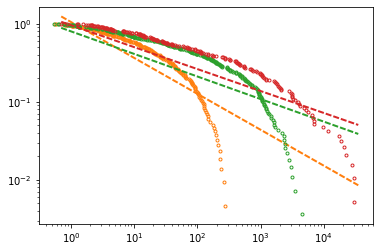

In [40]:
test = df
test1 = test[test['tstep'] == 100]
test2 = test[test['tstep'] == 150]
test3 = test[test['tstep'] == 175]
areas1 = test1['area']
areas2 = test2['area']
areas3 = test3['area']

x = np.linspace(min(areas3), max(areas3), 100)
areaList = [areas1, areas2, areas3]
cpdList = []
for a in areaList:
    alpha, amin, st, pval = powerlaw_bestFit(a, 1, 100, 5, 0.95)
    cpdList.append((amin/x)**(alpha-1))


dataCPD1 = normed_CPD(areas1)
dataCPD2 = normed_CPD(areas2)
dataCPD3 = normed_CPD(areas3)

plt.loglog(np.sort(areas1), dataCPD1, 'o', markersize = 3, fillstyle = 'none', color = 'C1')
plt.loglog(x, 0.5*cpdList[0], linestyle = '--', dashes = (3,1), linewidth = 2, color = 'C1')
plt.loglog(np.sort(areas2), dataCPD2, 'o', markersize = 3, fillstyle = 'none', color = 'C2')
plt.loglog(x, 0.5*cpdList[1], linestyle = '--', dashes = (3,1), linewidth = 2, color = 'C2')
plt.loglog(np.sort(areas3), dataCPD3, 'o', markersize = 3, fillstyle = 'none', color = 'C3')
plt.loglog(x, 0.5*cpdList[2], linestyle = '--', dashes = (3,1), linewidth = 2, color = 'C3')
plt.show()

In [5]:
"""
---INITIATE MODEL---
Function creates an empty list to store depressions. Run before beginning 
simulation loops.

Inputs: 
        None
Returns:
        Empty list to hold new depressions
"""
def initiate_model():
    return []


"""
---CREATE LIST OF LISTS TO SAVE DATA---
This function creates the list of lists for storing data from each timstep.

Inputs:
        None
Returns:
        This function returns an empty list of lists for use in the function
        save_timestep().
"""
def create_empty_data_lists():
    return [[], [], [], [], []]


"""
---ADD NEW DEPRESSIONS TO MODEL SPACE---
Adds new depressions to the model space. New depression coordinates are selected
from a normal distribution with shape equal to the model space dimensions.

Inputs:
        number = the number of new depressions to add
        model_size = the linear dimension of the square model space
        
Returns:
        Function returns a list of Shapely polygons. Return must be 
        converted to MultiPolygons or GeoSeries to plot. 

Dependencies:
        This function does not depend on any other functions in this model.

"""
def add_new_depressions(number, model_size):
    #Choose coordinates of new depression centers from normal distribution
    coordinates = [(np.random.uniform(low = 0, high = model_size), 
                    np.random.uniform(low = 0, high = model_size)) for i in range(number)]
    #Give new depressions an area selected from a lognormal distribution
    init_buffer = np.sqrt(np.random.lognormal(mean = 0.1, sigma = 0.5, size = number) / np.pi)
    #Buffer points to create polygon depressions, add depressions to list.
    polygons = [Point(coordinates[j]).buffer(init_buffer[j]) for j in range(number)]
    return polygons


"""
---CALCULATE CHANGE IN DEPRESSION AREA---
This function calculates the difference in area between two shapes. It is used
within scale_to_buffer to find the correct buffer value to achieve the desired
change in depression area. 

Inputs:
        x = buffer values (float)
        shape = Shapely polygon object
        a_next = the desired area value

Returns:
        Function returns difference in areas between two Shapely polygons.

Dependencies:
        This function is used within scale_to_buffer.
"""
def a_diff(x, shape, a_next):
    return a_next - shape.buffer(x).area


"""
---CALCULATE BUFFER VALUE---
This function approximates the buffer needed for the solution to the 
differential equation:
    dA/dt = cA^k
    dA = cA^k dt
    A_next - A_last = c*(A_last)^k *dt
    A_next = A_last + c*(A_last)^k *dt
to find the buffer value that gives the next area value.

Inputs:
        shape = Shapely polygon object
        scale_factor = exponent "k" in differential equation
        c = constant of proportionality in differential equation
        dt = timestep length
        
        ***Keep c*dt small to avoid model instability!***

Returns: 
        Function returns buffer value to increase shape area such that it 
        satisfies the differential equation above. Minimization uses 
        scipy.optimize.root. This method is faster than bisect

Dependencies:
        This function runs within the grow_depressions function.

c*dt needs to be small such that the dA is 'small' between timesteps
"""
def scale_to_buffer(shape, scale_factor, c, dt):
    a_next = c * dt * shape.area**scale_factor + shape.area
    sol = scipy.optimize.root(a_diff, [0], args = (shape, a_next))
    return sol.x[0]


"""
Model flow:
    1. Add initial depressions to the model space.
    2. Grow depressions.
    3. Merge overlapping depressions.
    4. Add new depressions.
    5. Repeat Steps 2, 3, and 4
"""

"""
---Grow depressions---
This function solves the next timestep of the differential equation:
    dA/dt = cA^k
    dA = cA^k dt
    A_next - A_last = c*(A_last)^k *dt
    A_next = A_last + c*(A_last)^k *dt

Inputs:
        shapes = list of Shapely polygons/points
        scale_factor = scaling exponent "k" in the differential equation
        c = proportionality constant 
        dt = timestep length
        
        ***Keep c*dt small to avoid model instability!***
        
Returns:
        Function returns python list of polygons. Must be coverted to MultiPolygons
        or GeoSeries to plot. 
"""
def grow_depressions(shapes, scale_factor, c, dt):
    #Convert list of polygons to class Shapely geometry MultiPolygons
    polys = geometry.MultiPolygon(shapes)
    #Create an array of buffers for depression growth
    bufferArray = np.array([scale_to_buffer(p, scale_factor, c, dt) for p in polys])
    #Increase depression areas using the buffer array
    scaledShapes = [Polygon(polys[k]).buffer(bufferArray[k]) for k in range(len(polys))]
    return scaledShapes


"""
---MERGE OVERLAPPING DEPRESSIONS---
This function uses Shapely's unary_union function to merge polygons. It does 
nothing new or unique outside of the unary_union. This function exists as a 
reminder of what the unary_union function is doing. 

Inputs:
        shapes = list of Shapely polygons
        
Returns:
        Function returns as list of Shapely Multipolygons. 
"""
def merge_depressions(shapes):
    if type(shapes) != 'Polygon':
        return list(unary_union(shapes))


"""
---SAVE TIMESTEP DATA---
This function records the timestep, total number of depressions added to the
model, total number of depressions (counting mergers), the areas, and the 
perimeters of each depression. 

Inputs:
        lists = Python list of lists, 
                rows represent ["t_step", "N_t", "N_m", "area", "perimeter"]
        shapes = Python list or Shapely MultiPolygons list
        tstep = timestep (iteration number)
        dt = timelegth of a single timestep 
        
Returns:
        Function returns updated list of lists. The lists are extended for 
        each successive timestep. 
        [[list of timesteps],
         [list of total number of depressions added to model space],
         [list of total number of depressions including mergers],
         [list of areas],
         [list of perimeters]]
"""
def save_timestep(lists, shapes, tstep, dt, n):
    areas = [s.area for s in shapes]
    perimeters = [s.length for s in shapes]
    N_t = int(np.floor((tstep) * dt)) * n + n
    N_m = len(areas)
    tstepList = [tstep for i in range(len(areas))]
    N_t_list = [N_t for i in range(len(areas))]
    N_m_list = [N_m for i in range(len(areas))]
    lists[0].extend(tstepList)
    lists[1].extend(N_t_list)
    lists[2].extend(N_m_list)
    lists[3].extend(areas)
    lists[4].extend(perimeters)
    return lists

In [13]:
def cumul_prob(data):
    data = np.sort(data)
    return np.array([(data[i] <= data).sum() for i in range(len(data))])

def normed_CPD(data):
    data = np.sort(data)
    prob = [(data[i] < data).sum() for i in range(len(data))]
    return prob / max(prob)

def calc_alpha(data, low_cutoff = None, high_cutoff = None):
    data = np.sort(data)
    if high_cutoff == None:
        high_cutoff = max(data)
    if low_cutoff == None:
        low_cutoff = min(data)
    data_cut = data[(data >= low_cutoff) & (data <= high_cutoff)]
    return 1 + len(data_cut) * (np.sum(np.log(data_cut / low_cutoff)))**-1

def calc_sigma(data, alpha, low_cutoff = None, high_cutoff = None):
    data = np.sort(data)
    if high_cutoff == None:
        high_cutoff = max(data)
    if low_cutoff == None:
        low_cutoff = min(data)
    data_cut = data[(data >= low_cutoff) & (data <= high_cutoff)]
    return (alpha - 1) / np.sqrt(len(data_cut))

def find_unique_pairs(data):
    uniques = np.unique(data)
    p1_list = []
    p2_list = []
    for n in uniques:
        index = np.where(uniques == n)
        index_n = int(index[0])
        for i in uniques[index_n + 1:]:
            p1_list.append(n)
            p2_list.append(i)
    return np.column_stack((p1_list, p2_list))

def max_likelihood_alpha(data, alpha, low_cutoff, high_cutoff):
    c = low_cutoff / high_cutoff
    data_cut = data[(data >= low_cutoff) & (data <= high_cutoff)]
    L = np.log((alpha - 1) / (1 - c**(alpha - 1))) - alpha * (np.sum(np.log(data_cut) / low_cutoff)) / len(data_cut)
    return L

def powerlaw_dist(exponent, low_cutoff, size = 2000):
    r = np.linspace(0, 0.99, size)
    pl_dist = low_cutoff * (1 - r)**(-1/(exponent - 1))
    return pl_dist

def powerlaw_bestFit(data, guess_low_cutoff, guess_upper_cutoff, step_size, pval_thresh):
    alpha = calc_alpha(data, guess_low_cutoff)
    a_range = np.arange(alpha - 0.1, alpha + 0.1, 0.01)
    cutoff_range = np.arange(0, guess_upper_cutoff, step_size)
    st_save = 1
    for a in a_range:
        for c in cutoff_range:
            data_cut = data[data > c]
            pl = powerlaw_dist(a, c)
            st, pval = stats.kstest(pl, data_cut)
            if st < st_save:
                st_save = np.round(st, 3)
                pval_save = np.round(pval, 3)
                a_save = np.round(a, 3)
                c_save = np.round(c, 3)
    if pval_save > pval_thresh:
        print('Fail to reject null hypothesis p > {}. Distributions are the same.'.format(pval_thresh))
        print('KS-statistic = {}, p = {}, alpha = {}, low cutoff = {}'.format (st_save, pval_save, a_save, c_save))
    elif pval_save < pval_thresh:
        print('Reject null hypothesis p < {}. Distributions are different.'.format(pval_thresh))
        print('KS-statistic = {}, p = {}, alpha = {}, low cutoff = {}'.format (st_save, pval_save, a_save, c_save))
    return a_save, c_save, st_save, pval_save